# Bert Classification example
This notebook is an example of training the BERT model for binary classification, with a max. sequence length of 256 for one epoch.  I use no evaluation during training as it slows the training down, if used, a val.tsv needs to be defined in the data/ directory, and the same preprocessing needs to be applied as for evaluation data (create_features and create_dataloader functions). 

In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

import torch

## Define dictionary containing all model and environmental parameters

In [15]:
task_name  = 'bert_256' 
params = {
    'data_dir': 'data/',                              # Directory of train.tsv, evaluation.tsv and test.tsv (optional)
    'params_dict_dir' : f'{task_name}_params.json',   # We save the dict here. It will be overwritten with more info. 
    'model_type':  'bert',                            # Defines the model type
    'model': 'bert-base-cased',                       # Defines the exact model
    'task_name': 'binary',
    'output_dir': f'outputs/{task_name}/',            # The output will be saved in the output/bert_128 directory
    'cache_dir': 'cache/',                            
    'do_train': True,                                 # Need to specify True for training
    'do_eval': False,                                 # Need to specify True for evaluation
    'evaluate_during_training': False,                # If True, evaluation during training -> necessite val.tsv in data/
                                                      # Note: the training will be very long if evaluate_during_training is chosen  
    'fp16': False,                                    # If True, decrease precision of all calculation (needs apex package)
    'fp16_opt_level': 'O1',                           # Precision level (only relevant if fp16 is defined True)
    'max_seq_len': 256,                               # Max text taken for one sentence
    'output_mode': 'classification',
    'train_batch_size': 16,
    'eval_batch_size': 16,

    'gradient_accumulation_steps': 1,
    'num_train_epochs': 1,
    'weight_decay': 0,
    'learning_rate': 4e-5,
    'adam_epsilon': 1e-8,
    'warmup_ratio': 0.06,
    'warmup_steps': 0,
    'max_grad_norm': 1.0,

    'logging_steps': 50,
    'evaluate_during_training': False,
    'save_steps': 2000,
    'eval_all_checkpoints': True,

    'overwrite_output_dir': False,
    'reprocess_input_data': True,
    'notes': 'Using IMDB dataset',
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

### Add tokenizer to the model

In [22]:
from pytorch_transformers import (WEIGHTS_NAME, BertConfig, BertForSequenceClassification, BertTokenizer,
                                  XLMConfig, XLMForSequenceClassification, XLMTokenizer, 
                                  XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer,
                                  RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer),
    'xlnet': (XLNetConfig, XLNetForSequenceClassification, XLNetTokenizer),
    'xlm': (XLMConfig, XLMForSequenceClassification, XLMTokenizer),
    'roberta': (RobertaConfig, RobertaForSequenceClassification, RobertaTokenizer)
}

config_class, model_class, tokenizer_class = MODEL_CLASSES[params['model_type']]

config = config_class.from_pretrained(params['model'], num_labels=2, finetuning_task=params['task_name'])
tokenizer = tokenizer_class.from_pretrained(params['model'])
params["tokenizer"] = tokenizer

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/reka/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": "binary",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.tokenization_utils:loading file https://s3.amazonaws.com/models.huggingface.co/bert

## Process data
### Create features from the data 

In [23]:
from modules.process import create_features

features, params = create_features(params, 'train')
eval_features, params = create_features(params, 'evaluation')
# Create val_features if evaluate during training is choosen
# val_features, params = create_features(params, 'val')

Loading features from cached file data/train_features_256_bert-base-cased..
Loading is finished from file data/train_features_256_bert-base-cased..
Adding train_example_length to the parameters dict and saving it in bert_256_params.json
Loading features from cached file data/evaluation_features_256_bert-base-cased..
Loading is finished from file data/evaluation_features_256_bert-base-cased..
Adding evaluation_example_length to the parameters dict and saving it in bert_256_params.json


### Create dataloaders

In [24]:
from modules.process import create_dataloader

# Create dataloader for train data
dataloader = create_dataloader(features, params, evaluation=False)
dataloader_name = f'{params["data_dir"]}dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(dataloader, dataloader_name)

# Create dataloader for eval data
eval_dataloader, all_label_ids = create_dataloader(eval_features, params, evaluation=True)
eval_dataloader_name = f'{params["data_dir"]}eval_dataloader_{params["max_seq_len"]}_{params["model"]}'
torch.save(eval_dataloader, eval_dataloader_name)
torch.save(all_label_ids, f'{params["data_dir"]}eval_label_ids')
           
# Create dataloader for eval data during training if evaluate_during_training is defined in params
# val_dataloader, all_label_ids = create_dataloader(val_features, params, evaluation=True)
# val_dataloader_name = f'{params["data_dir"]}val_dataloader_{params["max_seq_len"]}_{params["model"]}'
# torch.save(val_dataloader, val_dataloader_name)
#  torch.save(all_label_ids, f'{params["data_dir"]}eval_label_ids')

# Define model 

In [25]:
model = model_class.from_pretrained(params['model'])
model.to(params["device"])

INFO:pytorch_transformers.modeling_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/reka/.cache/torch/pytorch_transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.d7a3af18ce3a2ab7c0f48f04dc8daff45ed9a3ed333b9e9a79d012a0dedf87a6
INFO:pytorch_transformers.modeling_utils:Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "output_attentions": false,
  "output_hidden_states": false,
  "pruned_heads": {},
  "torchscript": false,
  "type_vocab_size": 2,
  "vocab_size": 28996
}

INFO:pytorch_transformers.modeling_utils:loading weights file https://s3.amazonaws.com/models.huggingface.co/bert

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

# Train

In [ ]:
from modules.model_functions import train

params['num_train_epochs'] = 6

if params['do_train'] and params['evaluate_during_training']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, val_dataloader)
elif params['do_train']: 
    model, train_loss_set, global_step, tr_loss = train(dataloader, model, params, eval_dataloader)

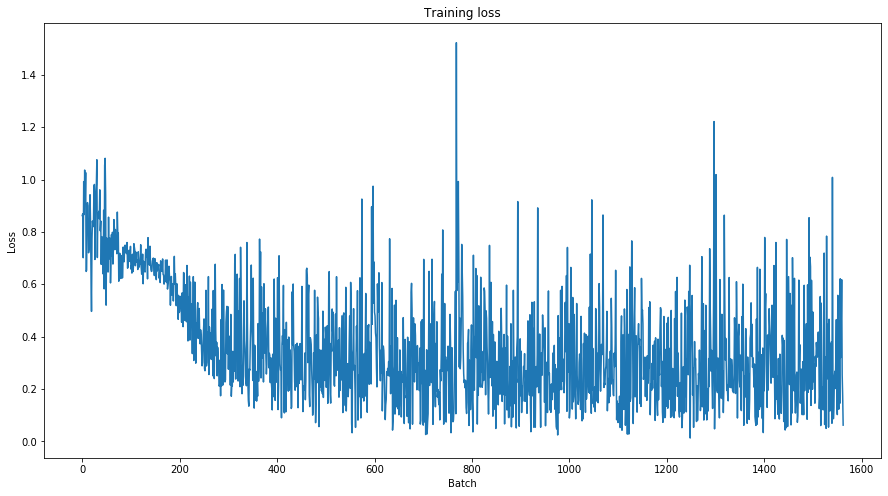

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

# Evaluation

In [31]:
from modules.model_functions import evaluate 

results = evaluate(model, eval_dataloader, params, prefix="")
results

INFO:modules.model_functions:***** Eval results  *****
INFO:modules.model_functions:  accuracy = 0.90752
INFO:modules.model_functions:  eval_loss = 0.2306000129155867
INFO:modules.model_functions:  f1-score = 0.9085515386440945
INFO:modules.model_functions:  fn = 1015
INFO:modules.model_functions:  fp = 1297
INFO:modules.model_functions:  logloss = 2.5634754175949097
INFO:modules.model_functions:  mcc = 0.8152474879757461
INFO:modules.model_functions:  model = bert-base-cased
INFO:modules.model_functions:  precision = 0.8985291816617118
INFO:modules.model_functions:  recall = 0.9188
INFO:modules.model_functions:  task_name = binary
INFO:modules.model_functions:  tn = 11203
INFO:modules.model_functions:  tp = 11485


{'mcc': 0.8152474879757461,
 'accuracy': 0.90752,
 'precision': 0.8985291816617118,
 'recall': 0.9188,
 'f1-score': 0.9085515386440945,
 'logloss': 2.5634754175949097,
 'tp': 11485,
 'tn': 11203,
 'fp': 1297,
 'fn': 1015,
 'task_name': 'binary',
 'model': 'bert-base-cased',
 'eval_loss': 0.2306000129155867}